### FT Data

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output, get_ingrs
from PIL import Image, ImageFile
import time
import pandas as pd

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [2]:
data_dir = '../data'

In [3]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [4]:
torch.cuda.is_available()

True

In [5]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'fittime_ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'fittime_instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [6]:
dataset = pickle.load(open(os.path.join(data_dir, 'train_dataset.pkl'), 'rb'))

In [7]:
dataset.describe()

[{'id': '77531_20181101_BREAKFAST',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['凤塔奈拉鹰嘴豆', '青稞', '桂冠鱼豆腐蟹肉蛋黄味', '水萝卜', '蒙牛风味酸牛奶(原味)'],
  'images': ['20181101/hotcamp_77531_20181101_BREAKFAST.jpg'],
  'title': []},
 {'id': '77538_20181101_BREAKFAST',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['芡实米', '白果(干)', '黄鱼(小黄花鱼)', '白玉菇', 'Tararua淡奶油奶酪'],
  'images': ['20181101/hotcamp_77538_20181101_BREAKFAST.jpg'],
  'title': []},
 {'id': '77532_20181101_BREAKFAST',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['豆浆(甜)'],
  'images': ['20181101/hotcamp_77532_20181101_BREAKFAST.jpg'],
  'title': []},
 {'id': '77534_20181102_LUNCH',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['竹荪(干)',
   '冬果梨',
   '西瓜子(熟)',
   'Familia瑞士麦无糖水果麦片',
   '葡萄酒（干白，11%，长城牌）'],
  'images': ['20181102/hotcamp_77534_20181102_LUNCH.jpg'],
  'title': []},
 {'id': '78457_20181102_LUNCH',
  'instructions': [],
  'tokenized': [],
  'ingredients': ['江米酒'],
  'images': ['20181

In [20]:
len(dataset)

39495

In [8]:
transf_list = []
transf_list.append(transforms.Resize(256))
transf_list.append(transforms.CenterCrop(224))
transform = transforms.Compose(transf_list)


85805_20190130_DINNER
['金枪鱼(盐水浸)', '蔬菜沙拉', '藜麦', '黄瓜', '芝麻酱']


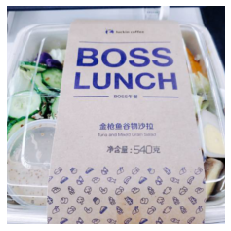

-----------------------------------------
85844_20190131_LUNCH
['杂粮粥（红豆+薏米）', '白斩鸡 （白切鸡）', '白灼芥蓝', '酱牛肉']


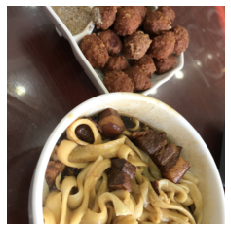

-----------------------------------------
77538_20190204_BREAKFAST
['意大利面', '四季豆', '鸡蛋', '纯牛奶', '食用油']


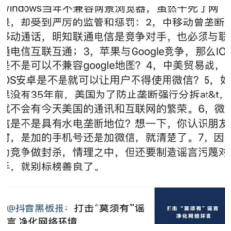

-----------------------------------------
85488_20190205_DINNER
['花卷', '紫薯', '紫菜(干)', '猪肉(瘦)', '青豆', '食用油']


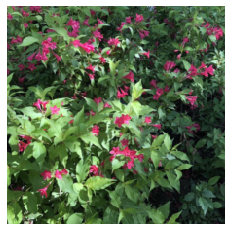

-----------------------------------------
77538_20190207_BREAKFAST
['燕麦麸', '莴笋', '鸡蛋', '纯牛奶', '食用油']


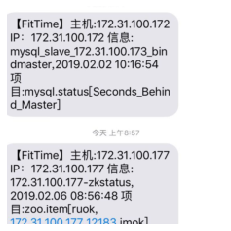

-----------------------------------------
85466_20190209_LUNCH
['面包', '小米', '木耳菜', '鸡肝', '食用油']


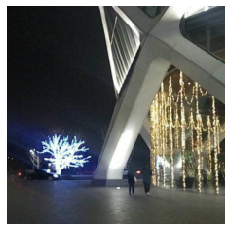

-----------------------------------------
85466_20190209_BREAKFAST
['全麦馒头', '胡萝卜', '鸡蛋', '纯牛奶', '食用油']


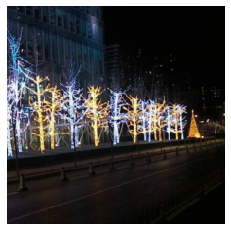

-----------------------------------------
77522_20190210_BREAKFAST
['杂粮粥', '豆角', '鸡蛋', '无糖酸奶', '食用油']


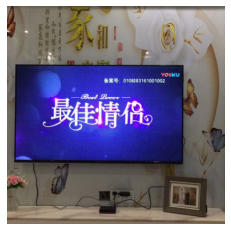

-----------------------------------------
85805_20190214_LUNCH
['米饭', '洋葱', '娃娃菜', '鸡胸肉', '葵花籽油']


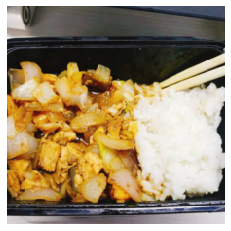

-----------------------------------------
86274_20190215_BREAKFAST
['好口福泡椒凤爪']


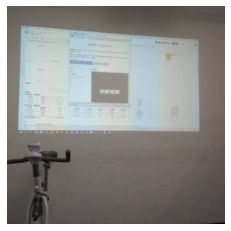

-----------------------------------------


In [9]:
image_dir = "/media/eganlau/meal_pictures/Images/"
ImageFile.LOAD_TRUNCATED_IMAGES = True

for data in dataset[10:20]:
    print(data["id"])
    print(data["ingredients"])
    image_transf = transform(Image.open(image_dir + data['images'][0]).convert('RGB'))
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    print("-----------------------------------------")


In [10]:
print (instrs_vocab_size, ingr_vocab_size)

3184 3184


In [18]:
ingr_df = pd.DataFrame(ingrs_vocab)
ingr_df.tail()

,0
3179,郫县辣酱
3180,光明 植物活力植物乳杆菌乳酸菌饮品（原味） 258ml
3181,宝矿力水特
3182,香橙水果馅饼
3183,<pad>


In [13]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
# args.maxseqlen = 15
args.ingrs_only=True
args.image_model='resnet50'
# args.embed_size=80
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join("../saved_models/inversecooking/model/checkpoints", 'model.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = True
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


loaded model
Elapsed time: 1.2554821968078613


In [14]:
        transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [15]:
greedy = [True, False, False, False]
beam = [-1, -1, -1, -1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [16]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs/fittime')

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']

demo_files = demo_urls if use_urls else demo_imgs

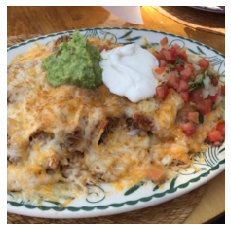

[ 2 14  1 27 12  7  9 15 34 22]
['食用油', '米饭', '鸡蛋', '猪肉(瘦)', '玉米（带棒心）', '牛肉(瘦)', '鸡胸肉', '生菜', '蒸红薯', '大白菜']
[ 2 14  1 27 12  7  9 15 34 22]
['食用油', '米饭', '鸡蛋', '猪肉(瘦)', '玉米（带棒心）', '牛肉(瘦)', '鸡胸肉', '生菜', '蒸红薯', '大白菜']
[ 2 14  1 27 12  7  9 15 34 22]
['食用油', '米饭', '鸡蛋', '猪肉(瘦)', '玉米（带棒心）', '牛肉(瘦)', '鸡胸肉', '生菜', '蒸红薯', '大白菜']
[ 2 14  1 27 12  7  9 15 34 22]
['食用油', '米饭', '鸡蛋', '猪肉(瘦)', '玉米（带棒心）', '牛肉(瘦)', '鸡胸肉', '生菜', '蒸红薯', '大白菜']


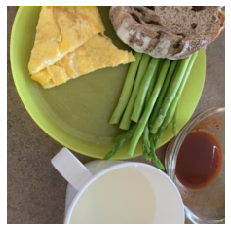

[  1   2  10  74   3   4  55  54 103  34]
['鸡蛋', '食用油', '全麦面包', '纯牛奶', '番茄', '黄瓜', '小米粥', '杂粮粥', '燕麦麸', '蒸红薯']
[  1   2  10  74   3   4  55  54 103  34]
['鸡蛋', '食用油', '全麦面包', '纯牛奶', '番茄', '黄瓜', '小米粥', '杂粮粥', '燕麦麸', '蒸红薯']
[  1   2  10  74   3   4  55  54 103  34]
['鸡蛋', '食用油', '全麦面包', '纯牛奶', '番茄', '黄瓜', '小米粥', '杂粮粥', '燕麦麸', '蒸红薯']
[  1   2  10  74   3   4  55  54 103  34]
['鸡蛋', '食用油', '全麦面包', '纯牛奶', '番茄', '黄瓜', '小米粥', '杂粮粥', '燕麦麸', '蒸红薯']


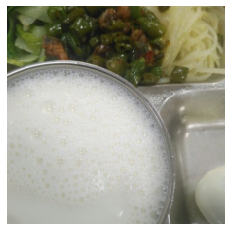

[ 2  1 74  5  6 10 14 12  4  3]
['食用油', '鸡蛋', '纯牛奶', '牛奶', '鸡蛋(煮)', '全麦面包', '米饭', '玉米（带棒心）', '黄瓜', '番茄']
[ 2  1 74  5  6 10 14 12  4  3]
['食用油', '鸡蛋', '纯牛奶', '牛奶', '鸡蛋(煮)', '全麦面包', '米饭', '玉米（带棒心）', '黄瓜', '番茄']
[ 2  1 74  5  6 10 14 12  4  3]
['食用油', '鸡蛋', '纯牛奶', '牛奶', '鸡蛋(煮)', '全麦面包', '米饭', '玉米（带棒心）', '黄瓜', '番茄']
[ 2  1 74  5  6 10 14 12  4  3]
['食用油', '鸡蛋', '纯牛奶', '牛奶', '鸡蛋(煮)', '全麦面包', '米饭', '玉米（带棒心）', '黄瓜', '番茄']


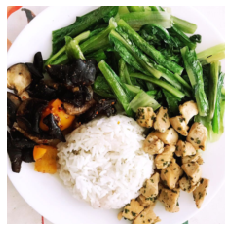

[ 2 14  1 27 22 15 31 34  9 24]
['食用油', '米饭', '鸡蛋', '猪肉(瘦)', '大白菜', '生菜', '鸡肉', '蒸红薯', '鸡胸肉', '卷心菜']
[ 2 14  1 27 22 15 31 34  9 24]
['食用油', '米饭', '鸡蛋', '猪肉(瘦)', '大白菜', '生菜', '鸡肉', '蒸红薯', '鸡胸肉', '卷心菜']
[ 2 14  1 27 22 15 31 34  9 24]
['食用油', '米饭', '鸡蛋', '猪肉(瘦)', '大白菜', '生菜', '鸡肉', '蒸红薯', '鸡胸肉', '卷心菜']
[ 2 14  1 27 22 15 31 34  9 24]
['食用油', '米饭', '鸡蛋', '猪肉(瘦)', '大白菜', '生菜', '鸡肉', '蒸红薯', '鸡胸肉', '卷心菜']


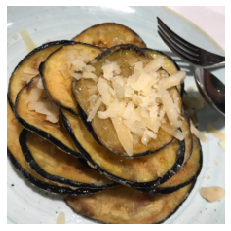

[ 2  1 14 27  3 34  8 12  9  7]
['食用油', '鸡蛋', '米饭', '猪肉(瘦)', '番茄', '蒸红薯', '红薯', '玉米（带棒心）', '鸡胸肉', '牛肉(瘦)']
[ 2  1 14 27  3 34  8 12  9  7]
['食用油', '鸡蛋', '米饭', '猪肉(瘦)', '番茄', '蒸红薯', '红薯', '玉米（带棒心）', '鸡胸肉', '牛肉(瘦)']
[ 2  1 14 27  3 34  8 12  9  7]
['食用油', '鸡蛋', '米饭', '猪肉(瘦)', '番茄', '蒸红薯', '红薯', '玉米（带棒心）', '鸡胸肉', '牛肉(瘦)']
[ 2  1 14 27  3 34  8 12  9  7]
['食用油', '鸡蛋', '米饭', '猪肉(瘦)', '番茄', '蒸红薯', '红薯', '玉米（带棒心）', '鸡胸肉', '牛肉(瘦)']


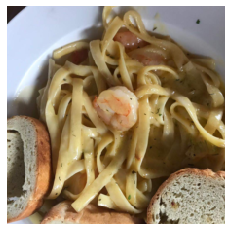

[ 2  1 10 34  3  8  4 14 27 15]
['食用油', '鸡蛋', '全麦面包', '蒸红薯', '番茄', '红薯', '黄瓜', '米饭', '猪肉(瘦)', '生菜']
[ 2  1 10 34  3  8  4 14 27 15]
['食用油', '鸡蛋', '全麦面包', '蒸红薯', '番茄', '红薯', '黄瓜', '米饭', '猪肉(瘦)', '生菜']
[ 2  1 10 34  3  8  4 14 27 15]
['食用油', '鸡蛋', '全麦面包', '蒸红薯', '番茄', '红薯', '黄瓜', '米饭', '猪肉(瘦)', '生菜']
[ 2  1 10 34  3  8  4 14 27 15]
['食用油', '鸡蛋', '全麦面包', '蒸红薯', '番茄', '红薯', '黄瓜', '米饭', '猪肉(瘦)', '生菜']


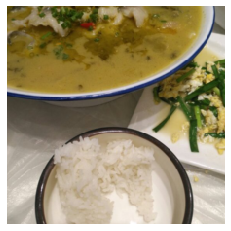

[ 2  1 14 27 55 13  4 34  7  9]
['食用油', '鸡蛋', '米饭', '猪肉(瘦)', '小米粥', '西兰花', '黄瓜', '蒸红薯', '牛肉(瘦)', '鸡胸肉']
[ 2  1 14 27 55 13  4 34  7  9]
['食用油', '鸡蛋', '米饭', '猪肉(瘦)', '小米粥', '西兰花', '黄瓜', '蒸红薯', '牛肉(瘦)', '鸡胸肉']
[ 2  1 14 27 55 13  4 34  7  9]
['食用油', '鸡蛋', '米饭', '猪肉(瘦)', '小米粥', '西兰花', '黄瓜', '蒸红薯', '牛肉(瘦)', '鸡胸肉']
[ 2  1 14 27 55 13  4 34  7  9]
['食用油', '鸡蛋', '米饭', '猪肉(瘦)', '小米粥', '西兰花', '黄瓜', '蒸红薯', '牛肉(瘦)', '鸡胸肉']


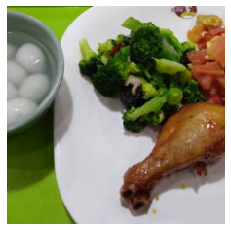

[ 1  2 10 74  3  4 34 23 11 55]
['鸡蛋', '食用油', '全麦面包', '纯牛奶', '番茄', '黄瓜', '蒸红薯', '胡萝卜', '橄榄油', '小米粥']
[ 1  2 10 74  3  4 34 23 11 55]
['鸡蛋', '食用油', '全麦面包', '纯牛奶', '番茄', '黄瓜', '蒸红薯', '胡萝卜', '橄榄油', '小米粥']
[ 1  2 10 74  3  4 34 23 11 55]
['鸡蛋', '食用油', '全麦面包', '纯牛奶', '番茄', '黄瓜', '蒸红薯', '胡萝卜', '橄榄油', '小米粥']
[ 1  2 10 74  3  4 34 23 11 55]
['鸡蛋', '食用油', '全麦面包', '纯牛奶', '番茄', '黄瓜', '蒸红薯', '胡萝卜', '橄榄油', '小米粥']


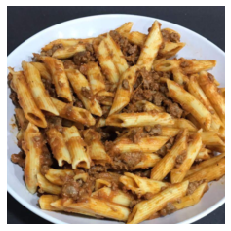

[ 2 14  1 27  9 34  8  7 12 42]
['食用油', '米饭', '鸡蛋', '猪肉(瘦)', '鸡胸肉', '蒸红薯', '红薯', '牛肉(瘦)', '玉米（带棒心）', '南瓜']
[ 2 14  1 27  9 34  8  7 12 42]
['食用油', '米饭', '鸡蛋', '猪肉(瘦)', '鸡胸肉', '蒸红薯', '红薯', '牛肉(瘦)', '玉米（带棒心）', '南瓜']
[ 2 14  1 27  9 34  8  7 12 42]
['食用油', '米饭', '鸡蛋', '猪肉(瘦)', '鸡胸肉', '蒸红薯', '红薯', '牛肉(瘦)', '玉米（带棒心）', '南瓜']
[ 2 14  1 27  9 34  8  7 12 42]
['食用油', '米饭', '鸡蛋', '猪肉(瘦)', '鸡胸肉', '蒸红薯', '红薯', '牛肉(瘦)', '玉米（带棒心）', '南瓜']


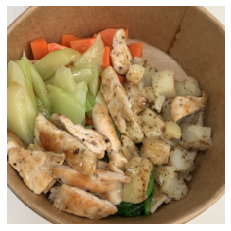

[ 2  1  3 14 34  8 27 10 20 74]
['食用油', '鸡蛋', '番茄', '米饭', '蒸红薯', '红薯', '猪肉(瘦)', '全麦面包', '意大利面', '纯牛奶']
[ 2  1  3 14 34  8 27 10 20 74]
['食用油', '鸡蛋', '番茄', '米饭', '蒸红薯', '红薯', '猪肉(瘦)', '全麦面包', '意大利面', '纯牛奶']
[ 2  1  3 14 34  8 27 10 20 74]
['食用油', '鸡蛋', '番茄', '米饭', '蒸红薯', '红薯', '猪肉(瘦)', '全麦面包', '意大利面', '纯牛奶']
[ 2  1  3 14 34  8 27 10 20 74]
['食用油', '鸡蛋', '番茄', '米饭', '蒸红薯', '红薯', '猪肉(瘦)', '全麦面包', '意大利面', '纯牛奶']


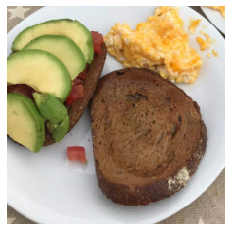

[ 2  1 74 10 55  6  5  4 13 14]
['食用油', '鸡蛋', '纯牛奶', '全麦面包', '小米粥', '鸡蛋(煮)', '牛奶', '黄瓜', '西兰花', '米饭']
[ 2  1 74 10 55  6  5  4 13 14]
['食用油', '鸡蛋', '纯牛奶', '全麦面包', '小米粥', '鸡蛋(煮)', '牛奶', '黄瓜', '西兰花', '米饭']
[ 2  1 74 10 55  6  5  4 13 14]
['食用油', '鸡蛋', '纯牛奶', '全麦面包', '小米粥', '鸡蛋(煮)', '牛奶', '黄瓜', '西兰花', '米饭']
[ 2  1 74 10 55  6  5  4 13 14]
['食用油', '鸡蛋', '纯牛奶', '全麦面包', '小米粥', '鸡蛋(煮)', '牛奶', '黄瓜', '西兰花', '米饭']


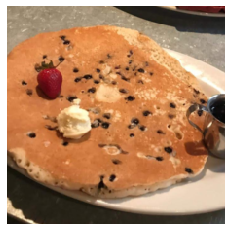

[ 2  1 14 27 12 34  8  9 15  7]
['食用油', '鸡蛋', '米饭', '猪肉(瘦)', '玉米（带棒心）', '蒸红薯', '红薯', '鸡胸肉', '生菜', '牛肉(瘦)']
[ 2  1 14 27 12 34  8  9 15  7]
['食用油', '鸡蛋', '米饭', '猪肉(瘦)', '玉米（带棒心）', '蒸红薯', '红薯', '鸡胸肉', '生菜', '牛肉(瘦)']
[ 2  1 14 27 12 34  8  9 15  7]
['食用油', '鸡蛋', '米饭', '猪肉(瘦)', '玉米（带棒心）', '蒸红薯', '红薯', '鸡胸肉', '生菜', '牛肉(瘦)']
[ 2  1 14 27 12 34  8  9 15  7]
['食用油', '鸡蛋', '米饭', '猪肉(瘦)', '玉米（带棒心）', '蒸红薯', '红薯', '鸡胸肉', '生菜', '牛肉(瘦)']


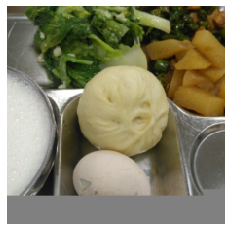

[ 2  1 74 55 10  6  5  4  3 13]
['食用油', '鸡蛋', '纯牛奶', '小米粥', '全麦面包', '鸡蛋(煮)', '牛奶', '黄瓜', '番茄', '西兰花']
[ 2  1 74 55 10  6  5  4  3 13]
['食用油', '鸡蛋', '纯牛奶', '小米粥', '全麦面包', '鸡蛋(煮)', '牛奶', '黄瓜', '番茄', '西兰花']
[ 2  1 74 55 10  6  5  4  3 13]
['食用油', '鸡蛋', '纯牛奶', '小米粥', '全麦面包', '鸡蛋(煮)', '牛奶', '黄瓜', '番茄', '西兰花']
[ 2  1 74 55 10  6  5  4  3 13]
['食用油', '鸡蛋', '纯牛奶', '小米粥', '全麦面包', '鸡蛋(煮)', '牛奶', '黄瓜', '番茄', '西兰花']


In [17]:
for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)

    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        print(ingr_ids[0])
        print(get_ingrs(ingr_ids[0], ingrs_vocab))